# Setup - defining parameters

In [1]:

#thresholds for spot detection (*std)
sigma1=50     #sigma of threshold for finding spots
sigma2=15     #sigma of threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10    #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="oct18"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [13]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
#sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import pfs.utils.coordinates.CoordTransp
import pfs.utils.coordinates.DistortionCoefficients

from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.vis_plot as visplot
except:
    import vis_plot as visplot




# connect to database (not done in calib mode)

In [14]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# parameters that change for each run

In [15]:

#set frame ID minimum and maximum values (inclusive)

#frameID=3666
frameID=1021

#source directory data files in local mode
#sourceDir="/Users/karr/Science/PFS/Firsts/"
# [HS] Added PU-specific directory
sourceDir="/tigress/HSC/PFS/mcs/2018-10-24"
fPref="PFSC"

#subtitle for plots - currently set to first frame ID plus tag
stitle=""

moveID=0
#get list of file names
fname,prefix=vis.getFileName(frameID,moveID,sourceDir,fPref,dataType='pinhole')


## expected get positions of cobras (not during calib)

In [16]:
reload(fps)

#get instrument parameters
rotCent,offset=vis.loadInstParams('oct18')
#get spot positions in PFI mm
fiducials,scienceFibres=fps.getFieldDefinition('')
#transform
fibrePos=fps.getFibrePos(fiducials,scienceFibres,0,180,rotCent,offset)


Scaling


# calculate threshold values and region (once per config)

In [17]:
#not needed if pulling from DB
reload(vis)
reload(fps)
reload(mcs)
config='calib'

if((cenFlag=='local')):
    
    image=vis.getImage(fname)

    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        thresh1,thresh2,xrange,yrange=mcs.getThresh(image,'calib',4,2,sigma1,sigma2)
        
    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        thresh1,thresh2,xrange,yrange=mcs.getThresh(image,'fieldID',4,2,sigma1,sigma2,fibrePos=fibrePos)
        

print("Thresholds=",thresh1,thresh2)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])


Thresholds= 1967.38231273 1202.49033214
Boundaries of region (x1,x2,y1,y2):  180 4072 2611 6542


# Do the centroiding for a set of database, either locally or retrieve from DB


<IPython.core.display.Javascript object>


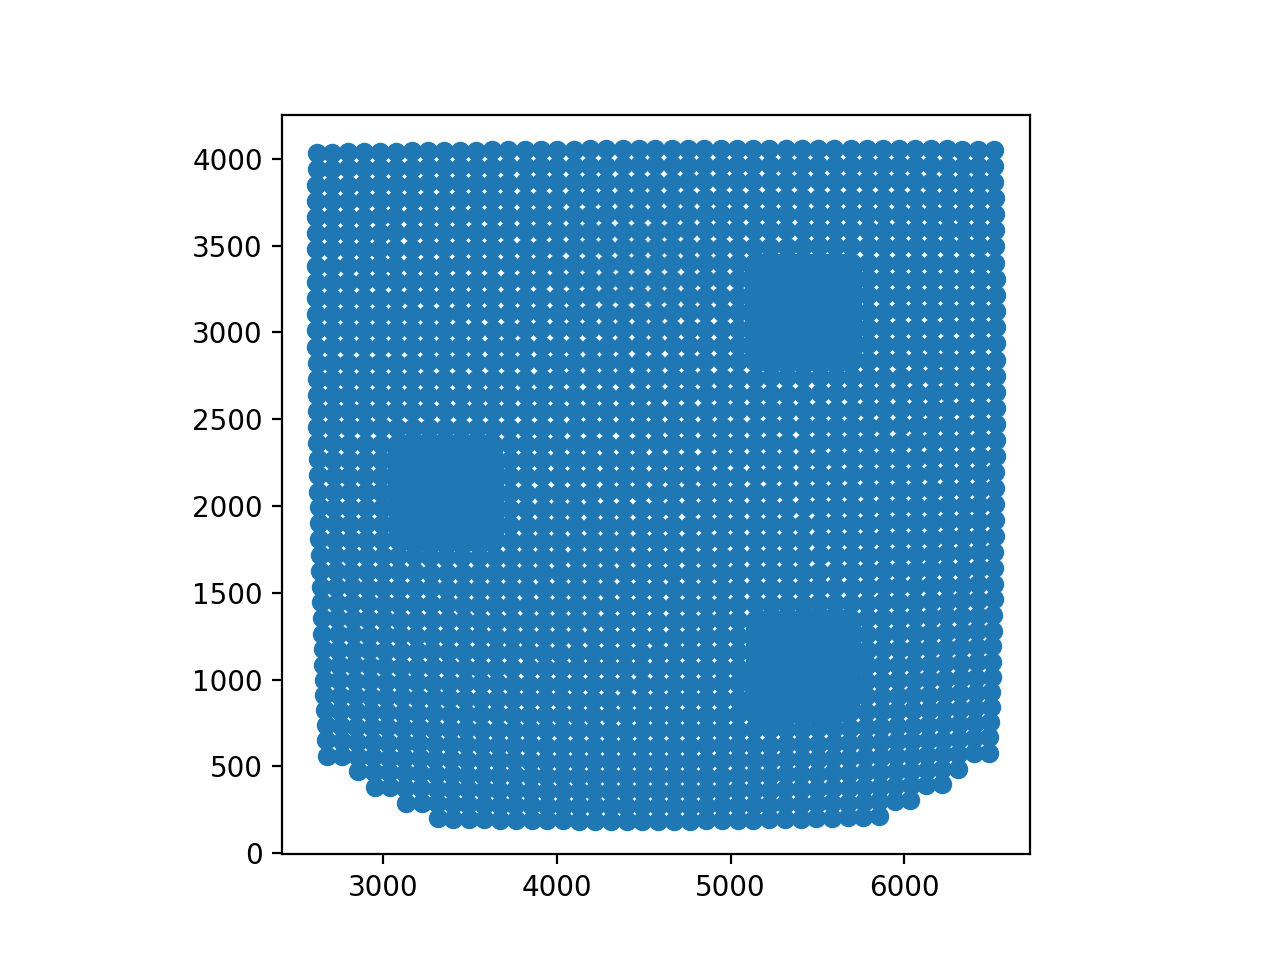

In [18]:
reload(vis)

reload(visplot)

#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):
    image=vis.getImage(fname)

    boxFind=10
    centroids=vis.getCentroids(image,thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
    #db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameIDs)        

x=centroids[:,1]
y=centroids[:,2]
fx=centroids[:,3]    
fy=centroids[:,4]
peak=centroids[:,5]
back=centroids[:,6]
    
visplot.checkCentroids(x,y,1,prefix,inter)




## Match points to expected positions

In [19]:
reload(mcs)
reload(fps)

#match all the frames to the first frame
tol=50
mCentroid=mcs.findHomes(centroids,fibrePos,tol)
dx,dy = fps.getDiff(mCentroid,fibrePos)



# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values. Change "plotRange" to adjust the range. 


<IPython.core.display.Javascript object>


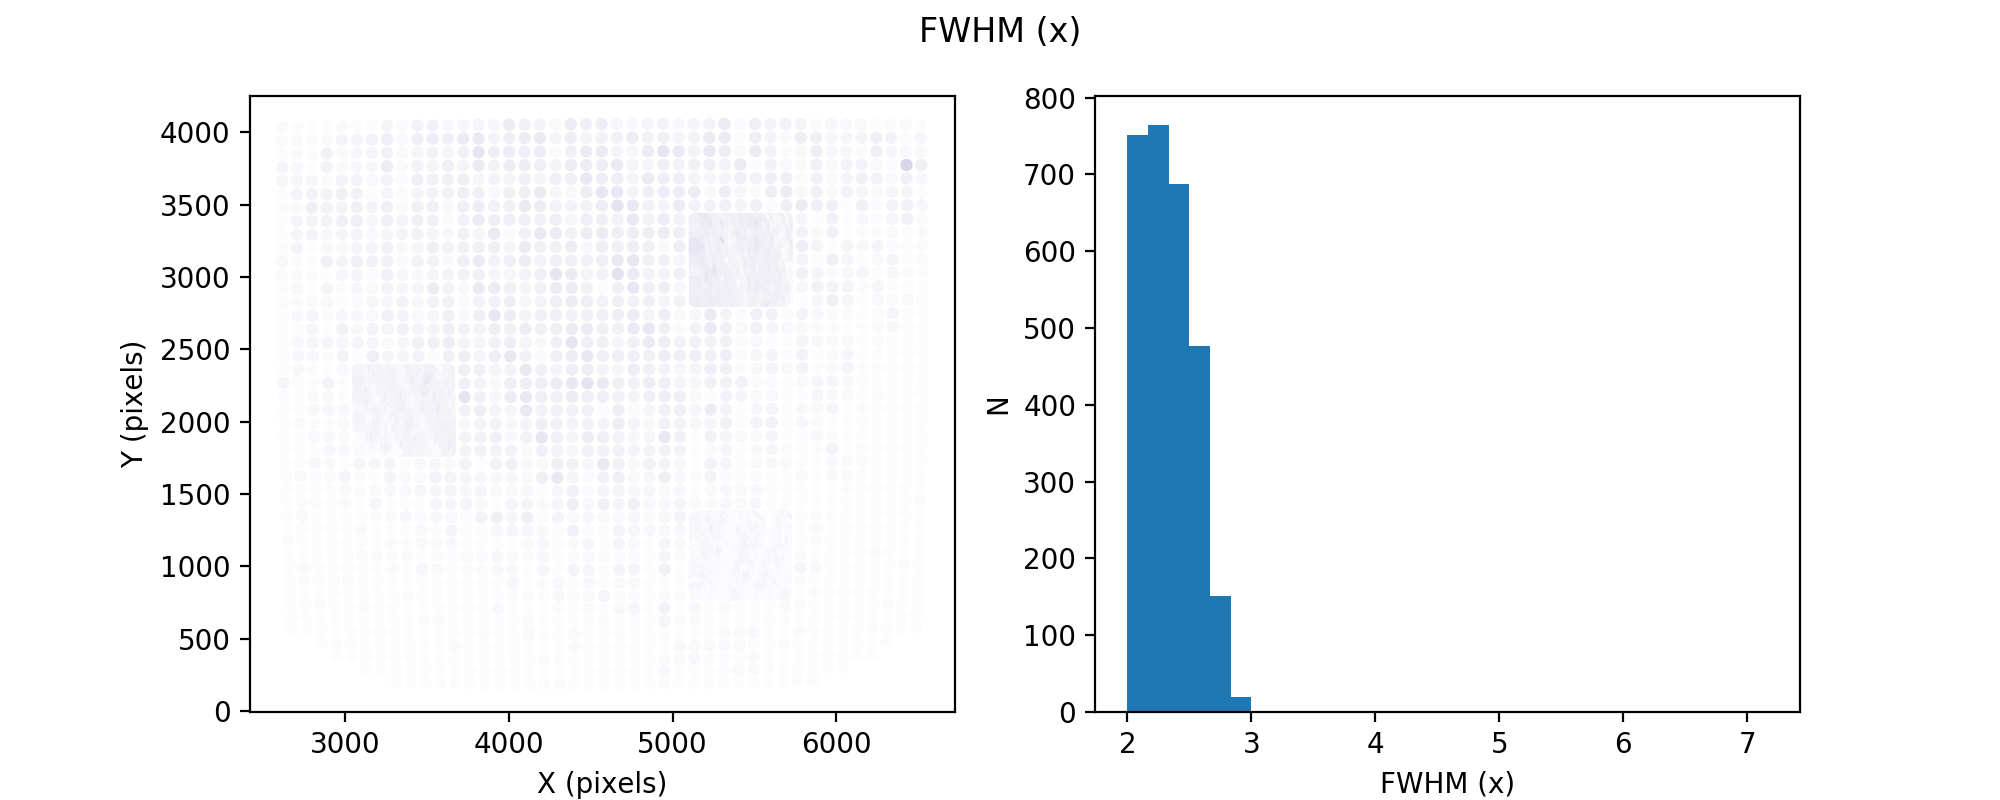

<IPython.core.display.Javascript object>


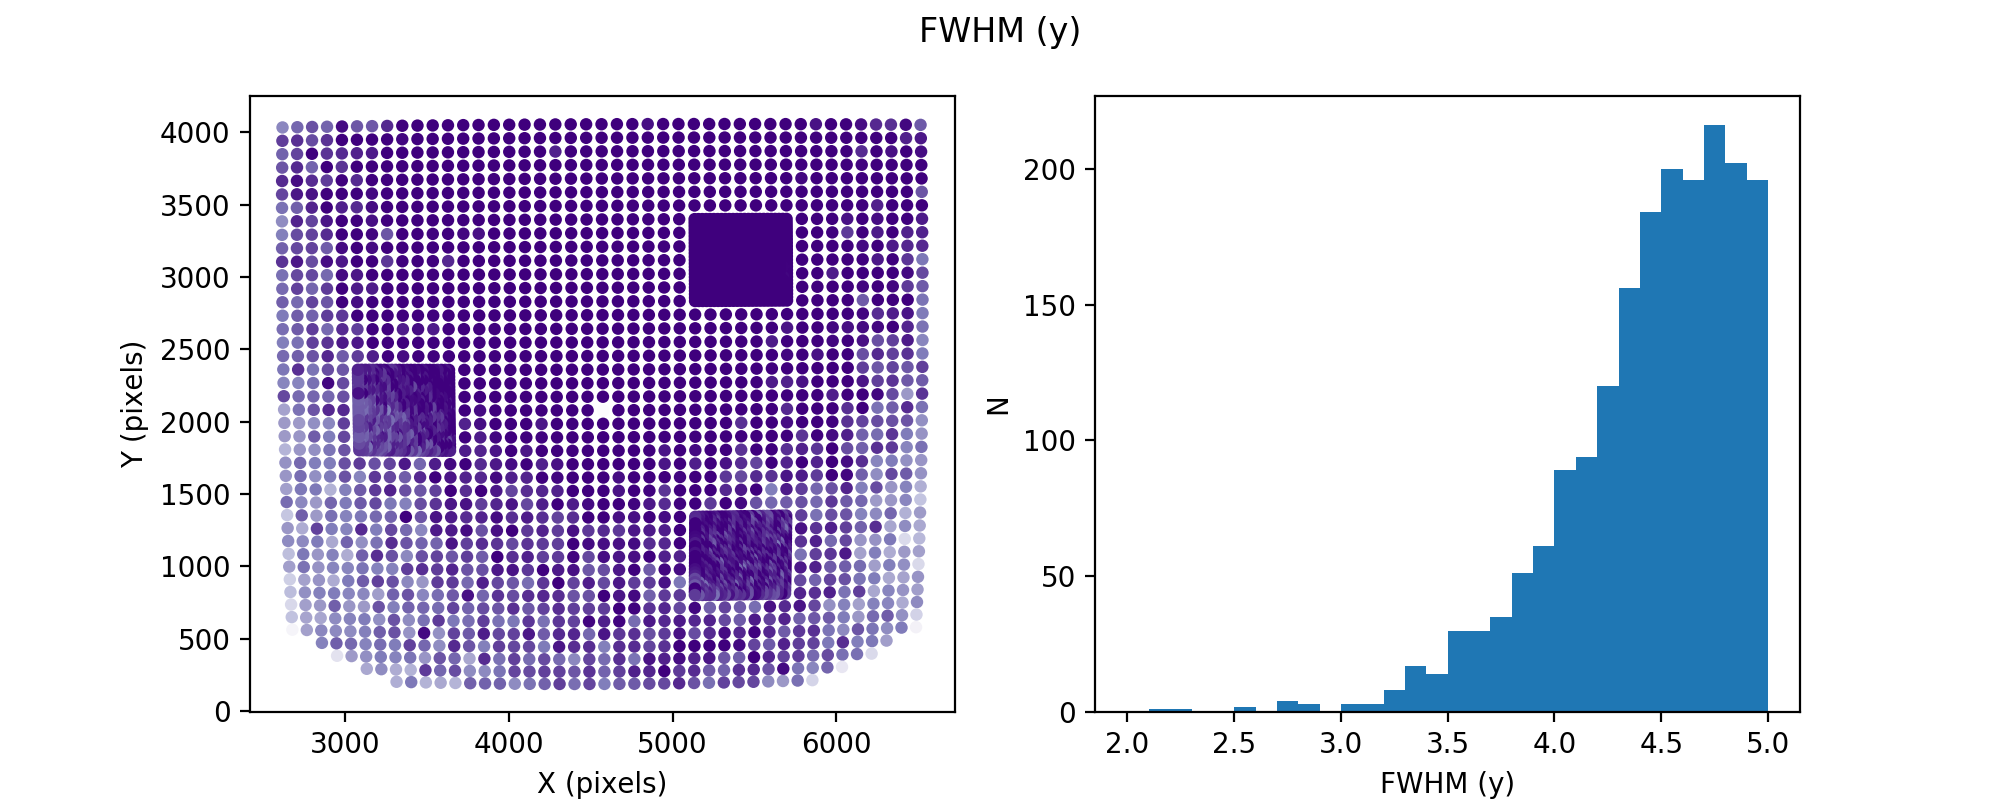

<IPython.core.display.Javascript object>


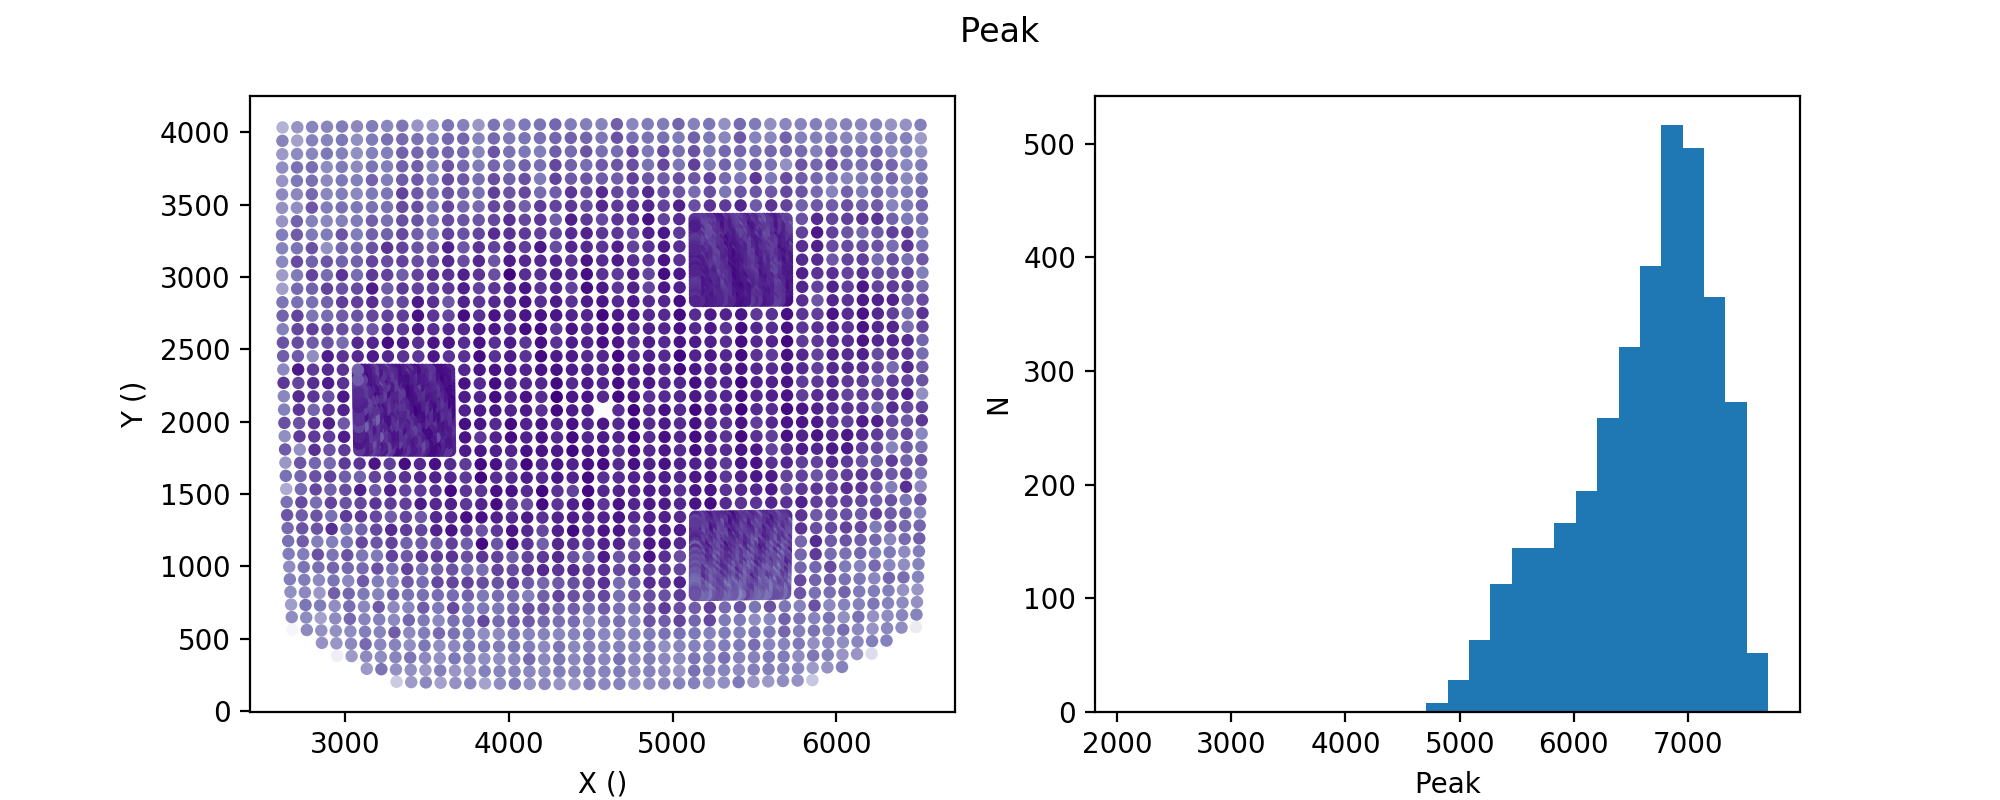

In [20]:
reload(visplot)

plotRange=None
nbins=30

plotRange=[2,7]
visplot.pairPlot(x,y,fx,fx,plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,5]
visplot.pairPlot(x,y,fy,fy,plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)
plotRange=[peak.min(),peak.max()]
visplot.pairPlot(x,y,peak,peak,plotRange,"Peak",prefix,"_peak","Peak","",nbins,inter,stitle=stitle)


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


<IPython.core.display.Javascript object>


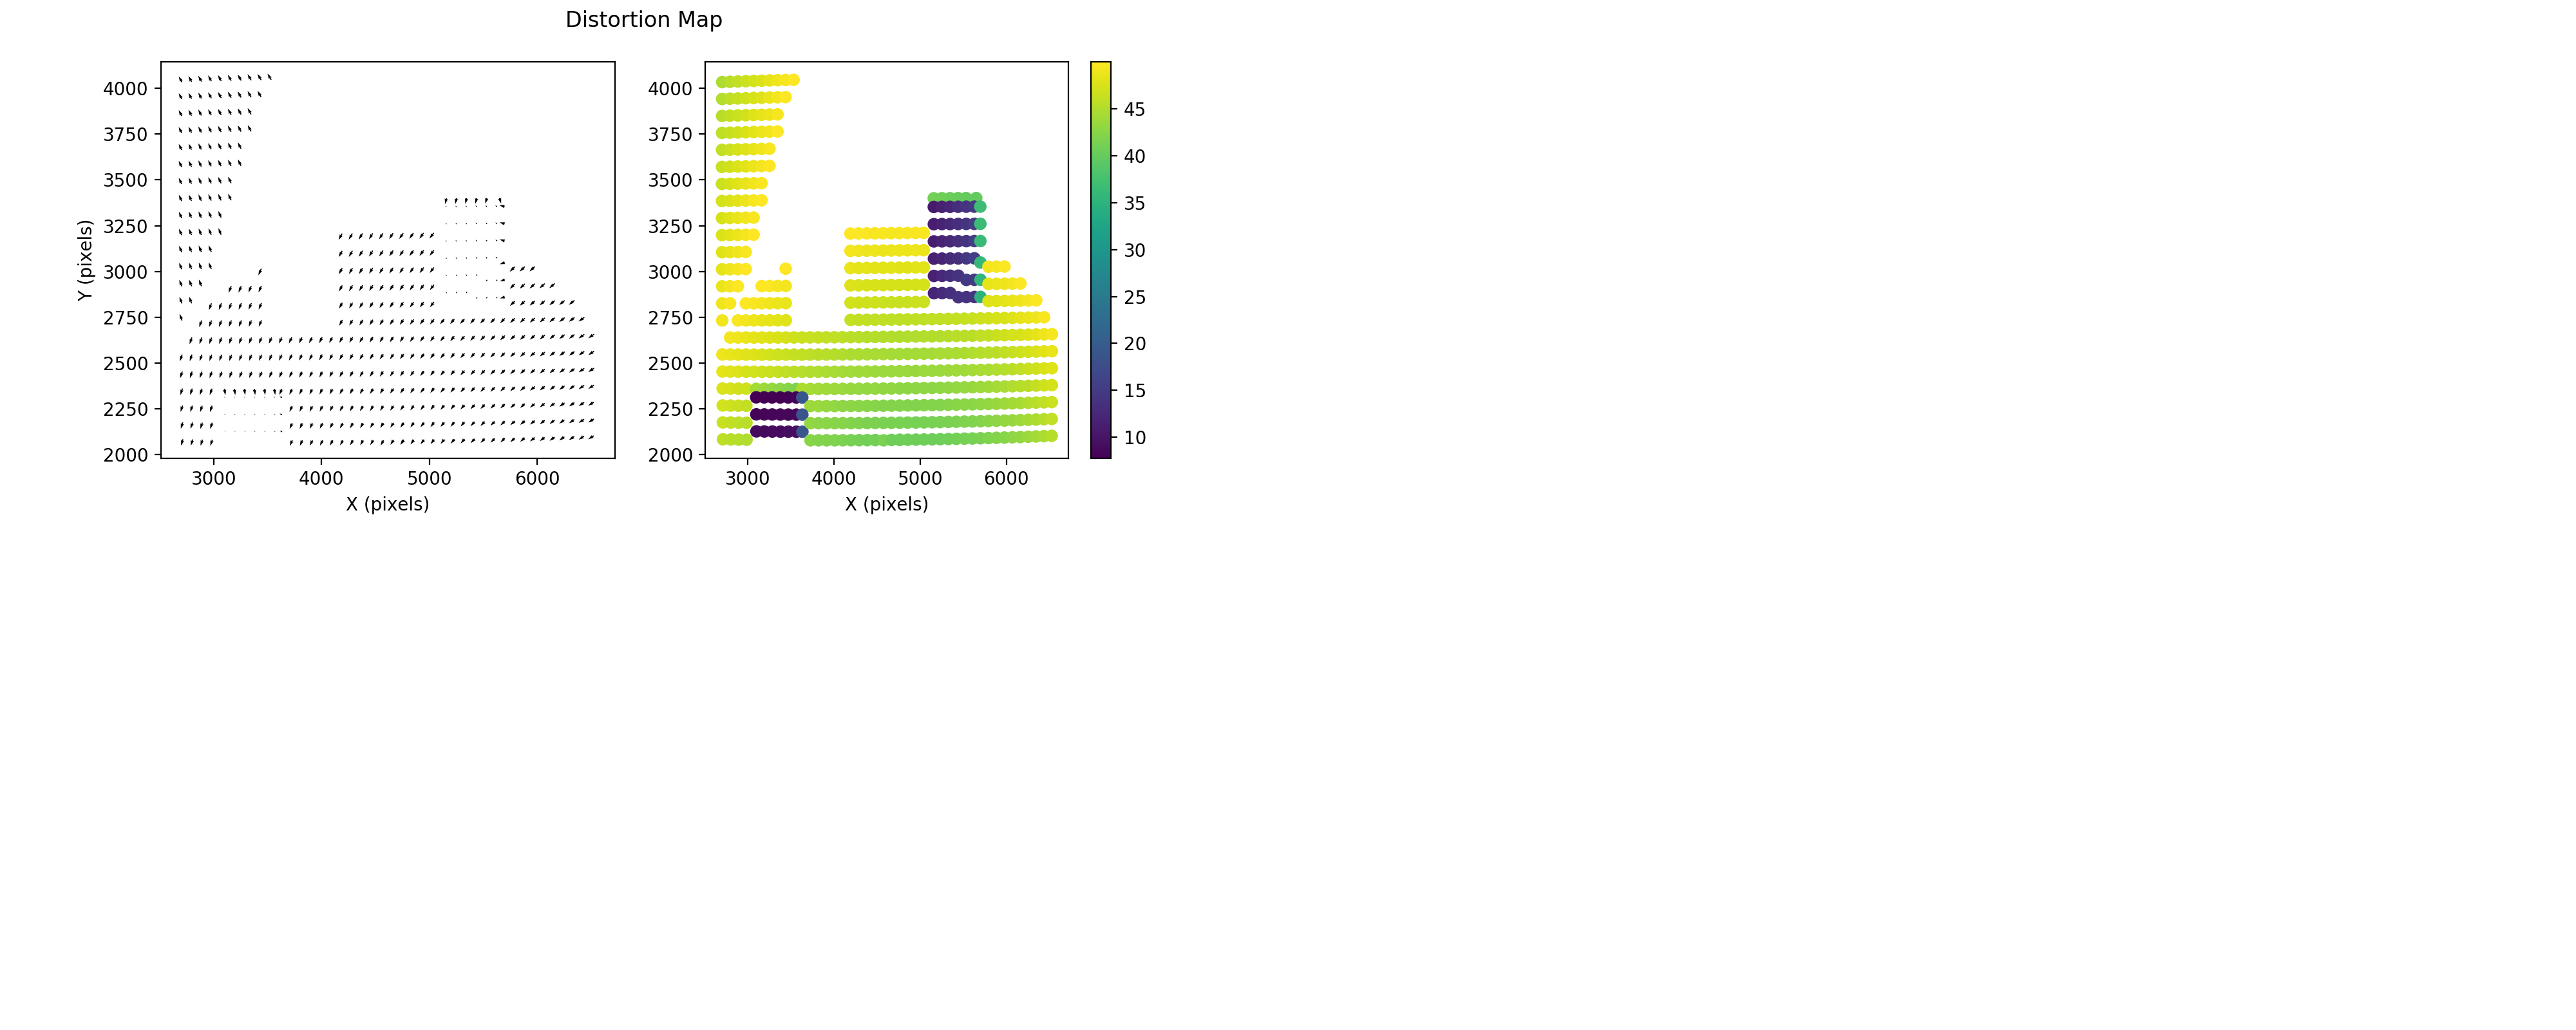

(1703,) (1703,) (1703,) (1703,)


In [21]:
reload(visplot)
visplot.quiverPlot(mCentroid[:,1],mCentroid[:,2],dx,dy)
print(mCentroid[:,1].shape,mCentroid[:,2].shape,dx.shape,dy.shape)


<IPython.core.display.Javascript object>


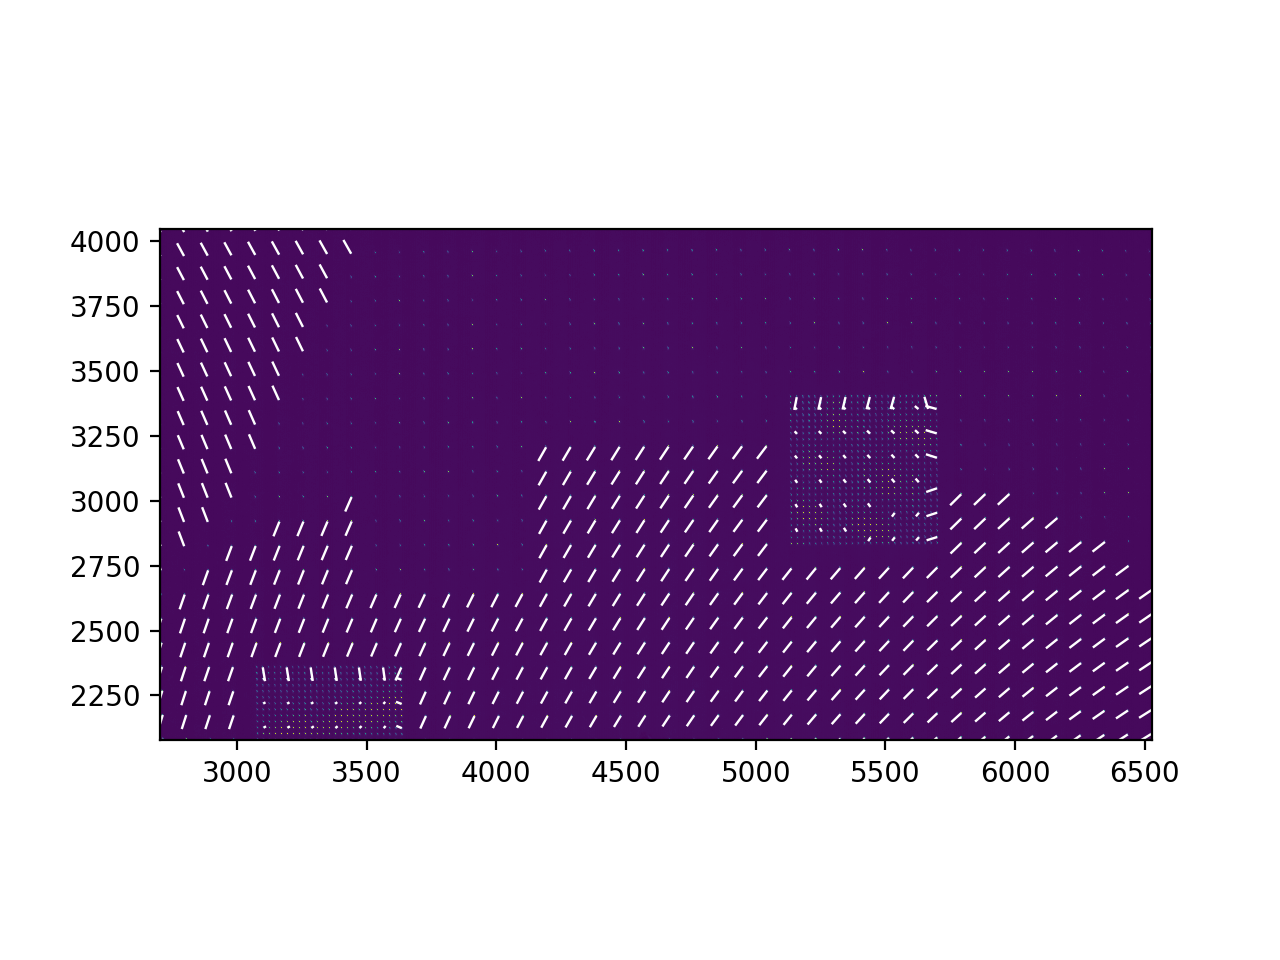

2703.48734049 6527.87253562 2076.62647017 4047.14680014


In [23]:
reload(visplot)
visplot.diagPlot(image,mCentroid,dx,dy)


<IPython.core.display.Javascript object>


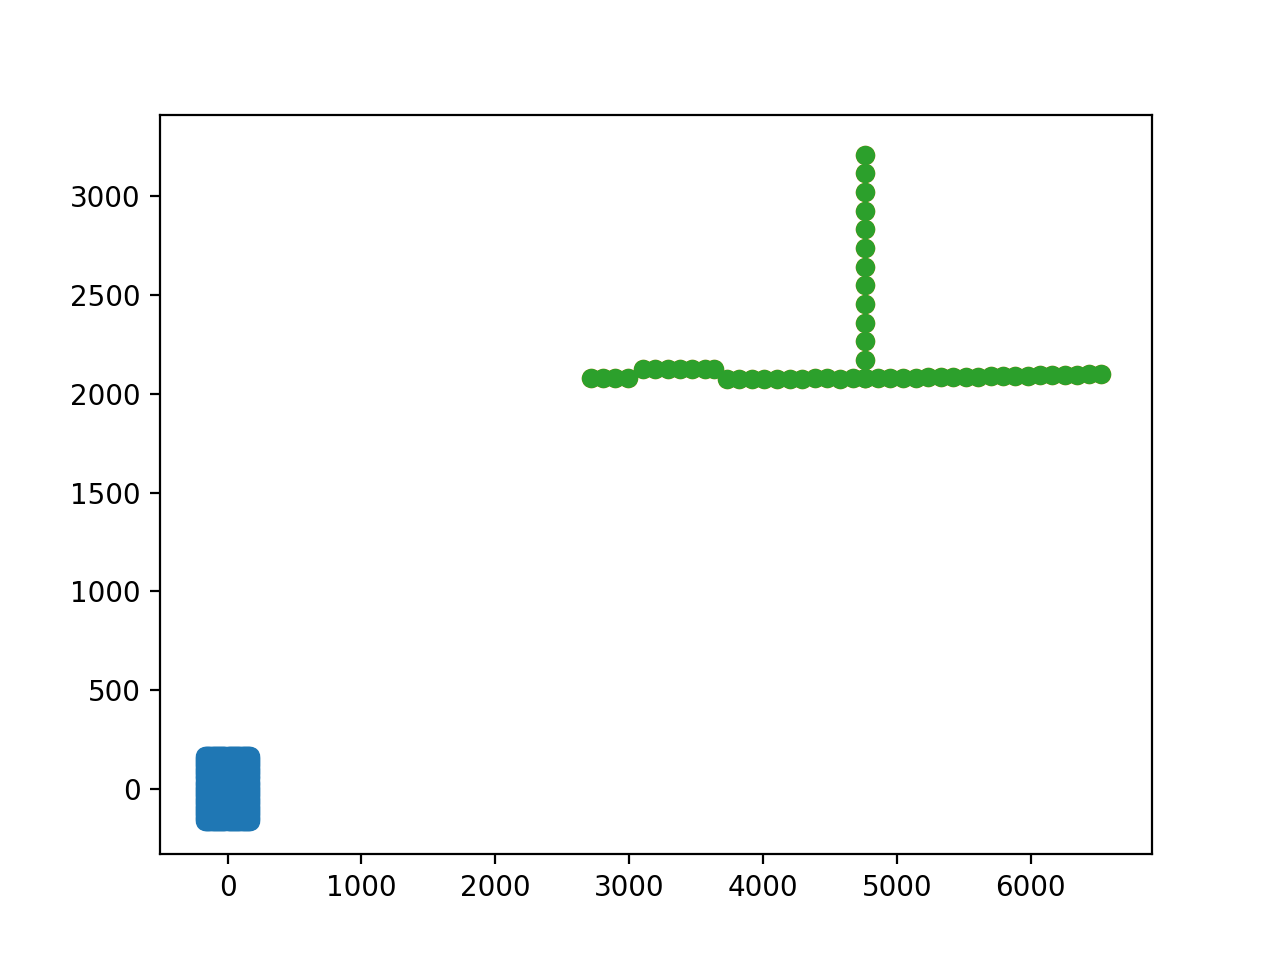

In [28]:



fig,ax=plt.subplots()
ax.scatter(scienceFibres[:,1],scienceFibres[:,2])
ax.scatter(mCentroid[0:129,1],mCentroid[0:129,2])
ax.scatter(mCentroid[0:129,1],mCentroid[0:129,2])
fig.show()